<a href="https://colab.research.google.com/github/envgp/taking_the_pulse_atmosphere/blob/main/pulse_atmosphere_greenhouse_gases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1: Atmosphere: Green House Gases

Rosemary Knight (rknight@stanford.edu) & Seogi Kang (sgkang09@stanford.edu), Stanford Environmental Geophysics Group

This week, we will explore green houses gases including CO2, CH4, NO2, XXX in the atmospheric system, which drives the climate change. Data sets used this lab are: 1) XXX. 

XXX

In [ ]:
!pip install xarray numpy pandas geopandas cartopy==0.19.0.post1 ipywidgets

In [ ]:
!pip uninstall -y shapely

Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1


In [ ]:
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.0.tar.gz (274 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached Shapely-1.8.5.post1.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.5.post1-cp38-cp38-linux_x86_64.whl size=755479 sha256=d1c19370c1d35b9c2c56446e0a914e475ef80a647b01bff34ecfec5829c94a62
  Stored in directory: /root/.cache/pip/wheels/1e/b7/86/5badb596b4dcdcb8f0fa49a4b83e7d934681843c6dc406b16d
Successfully built shapely


## Download required data

In [ ]:
!git clone https://premonition.stanford.edu/sgkang09/taking_the_pulse_atmosphere_data.git

fatal: destination path 'taking_the_pulse_atmosphere_data' already exists and is not an empty directory.


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import warnings
warnings.filterwarnings('ignore')
# matplotlib.rcParams['font.size'] = 14

UsageError: Line magic function `%` not found.


## CO2 data

### Understanding data


<img src="https://climate.nasa.gov/rails/active_storage/blobs/redirect/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbTB1IiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--316f6ecc3277fe90f8001ccabd62210d74792a1d/co2_left_061720.gif?disposition=inline"></img>

Data source: Reconstruction from ice cores.

Credit: NOAA


[COPIED FROM NASA WEBPAGE]

The first graph shows atmospheric CO2 levels measured at Mauna Loa Observatory, Hawaii, in recent years, with natural, seasonal changes removed. The second graph shows CO2 levels during Earth’s last three glacial cycles, as captured by air bubbles trapped in ice sheets and glaciers.

Since the beginning of industrial times (in the 18th century), human activities have raised atmospheric CO2 by 50% – meaning the amount of CO2 is now 150% of its value in 1750. This is greater than what naturally happened at the end of the last ice age 20,000 years ago.

Let's start with a monthly time-series of CO2 level measured at Mauna Loa Observatory. We are going to read the CO2 level a csv format using `pandas`. 

In [ ]:
df_co2 = pd.read_csv('./taking_the_pulse_atmosphere_data/co2_gml.csv')

In [ ]:
df_co2.head()

,year,month,monthly_average_co2,de-seasonalized_co2
0,1958.0,3.0,315.70,314.43
1,1958.0,4.0,317.45,315.16
2,1958.0,5.0,317.51,314.71
3,1958.0,6.0,317.24,315.14
4,1958.0,7.0,315.86,315.18


In [ ]:
# generate DatetimeIndex from years and months
years = df_co2['year'].values.astype(int)
months = df_co2['month'].values.astype(int)
times = [datetime.date(years[ii], months[ii], 1) for ii in range(df_co2.shape[0])]
time_series = pd.to_datetime(times)
df_co2['time'] = time_series
df_co2 = df_co2.set_index('time')

In [ ]:
df_co2.head(3)

,year,month,monthly_average_co2,de-seasonalized_co2
time,,,,
1958-03-01,1958.0,3.0,315.70,314.43
1958-04-01,1958.0,4.0,317.45,315.16
1958-05-01,1958.0,5.0,317.51,314.71


Although the table includes `de-seasonalized_co2`, as an exercise we are going to remove seasonal changes by using a moving average. 

In [ ]:
df_series = df_co2['monthly_average_co2'].rolling(window=12, center=True).mean()

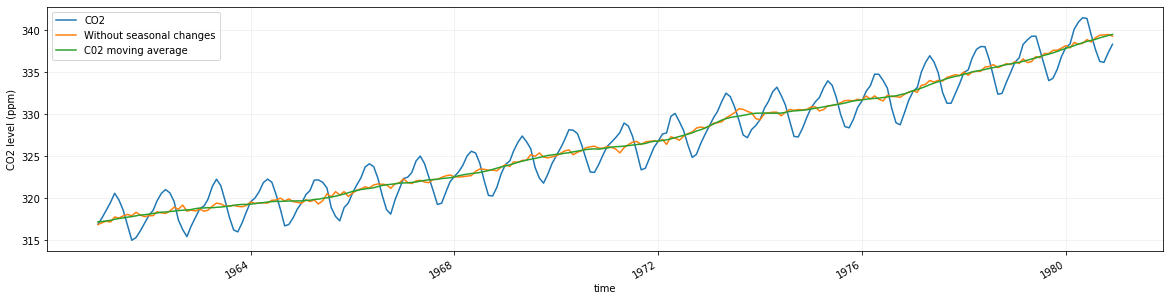

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
year_min = 1960
year_max = 1980
index_time = np.logical_and(year_min<time_series.year, year_max>=time_series.year)
ax.plot(time_series[index_time], df_co2['monthly_average_co2'].values[index_time], label="CO2", marker='None')
ax.plot(time_series[index_time], df_co2['de-seasonalized_co2'].values[index_time], label="Without seasonal changes", marker='None')
df_series.loc[time_series[index_time]].plot(label='C02 moving average')
ax.grid(True, alpha=0.2)
ax.set_ylabel("CO2 level (ppm)")

ax.legend()

Trend estimation



Now, we are going to load the gridded CO2 data measured ...

In [ ]:
co2_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/co2.nc')

In [ ]:
co2_data

<xarray.Dataset>
Dimensions:  (time: 84, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2021-12-31
  * lon      (lon) float64 -179.8 -178.8 -177.8 -176.8 ... 177.2 178.2 179.2
  * lat      (lat) float64 89.75 88.75 87.75 86.75 ... -87.25 -88.25 -89.25
Data variables:
    co2      (time, lat, lon) float64 400.6 400.6 400.6 ... 411.5 411.5 411.5
Attributes:
    Description:    CO2 data
    Unit:           ppm
    Data document:  TBA

In [ ]:
co2_data.time.min()

<xarray.DataArray 'time' ()>
array('2015-01-31T00:00:00.000000000', dtype='datetime64[ns]')

In [ ]:

co2_data.time.max()

<xarray.DataArray 'time' ()>
array('2021-12-31T00:00:00.000000000', dtype='datetime64[ns]')

In [ ]:
co2_data.lon

<xarray.DataArray 'lon' (lon: 360)>
array([-179.75, -178.75, -177.75, ...,  177.25,  178.25,  179.25])
Coordinates:
  * lon      (lon) float64 -179.8 -178.8 -177.8 -176.8 ... 177.2 178.2 179.2

In [ ]:
# co2_data

In [ ]:

co2_data.co2

<xarray.DataArray 'co2' (time: 84, lat: 180, lon: 360)>
array([[[400.6151123 , 400.61505127, 400.61502075, ..., 400.61523438,
         400.61520386, 400.61517334],
        [400.71902466, 400.71893311, 400.71859741, ..., 400.71783447,
         400.7182312 , 400.71862793],
        [400.72894287, 400.7288208 , 400.72869873, ..., 400.72906494,
         400.72924805, 400.72912598],
        ...,
        [394.574646  , 394.57662964, 394.57861328, ..., 394.56866455,
         394.57067871, 394.57263184],
        [394.56524658, 394.565979  , 394.56671143, ..., 394.56329346,
         394.56378174, 394.56451416],
        [394.60009766, 394.60055542, 394.60101318, ..., 394.59881592,
         394.59924316, 394.59967041]],

       [[401.97235107, 401.97198486, 401.97161865, ..., 401.97344971,
         401.9730835 , 401.97271729],
        [401.92962646, 401.92816162, 401.92669678, ..., 401.93423462,
         401.93267822, 401.93115234],
        [401.82165527, 401.81915283, 401.81674194, ..., 401.82965088,
         401.82684326, 401.82418823],
...
        [411.5645752 , 411.56726074, 411.56994629, ..., 411.55615234,
         411.55899048, 411.5617981 ],
        [411.57235718, 411.57275391, 411.57312012, ..., 411.57138062,
         411.57141113, 411.57189941],
        [411.6293335 , 411.62976074, 411.63018799, ..., 411.62817383,
         411.62854004, 411.62890625]],

       [[417.90008545, 417.90002441, 417.8999939 , ..., 417.90020752,
         417.90014648, 417.90011597],
        [417.88592529, 417.88543701, 417.88500977, ..., 417.88787842,
         417.88720703, 417.88653564],
        [417.89752197, 417.89593506, 417.89434814, ..., 417.90258789,
         417.9006958 , 417.89910889],
        ...,
        [411.49700928, 411.49954224, 411.5020752 , ..., 411.48901367,
         411.49169922, 411.49435425],
        [411.48376465, 411.48413086, 411.48455811, ..., 411.48352051,
         411.4831543 , 411.48345947],
        [411.53088379, 411.53097534, 411.53112793, ..., 411.5305481 ,
         411.53063965, 411.5307312 ]]])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2021-12-31
  * lon      (lon) float64 -179.8 -178.8 -177.8 -176.8 ... 177.2 178.2 179.2
  * lat      (lat) float64 89.75 88.75 87.75 86.75 ... -87.25 -88.25 -89.25

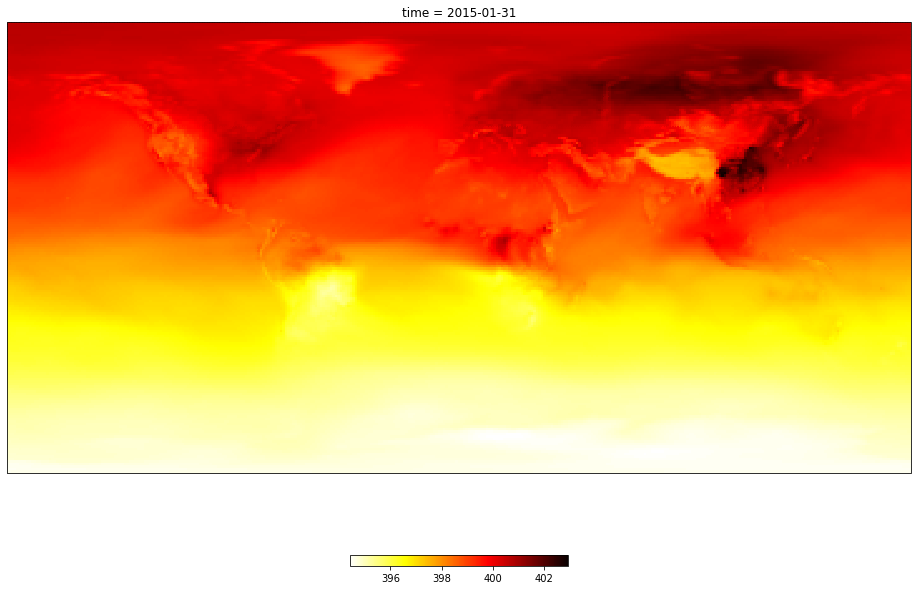

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
out = co2_data.co2.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r')
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

Text(0.5, 0, 'CO2 level (ppm)')

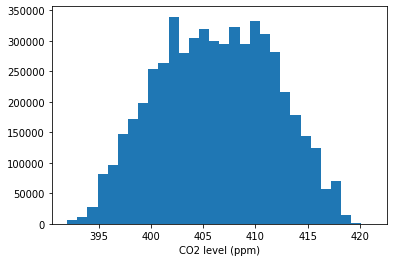

In [ ]:
out = plt.hist(co2_data.co2.data.flatten(), bins=30)
plt.xlabel("CO2 level (ppm)")

In [ ]:
from ipywidgets import widgets, interact
def plot_co2(i_time):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    out = co2_data.co2.isel(time=i_time).plot(
        ax=ax, add_colorbar=False, cmap='hot_r', 
        vmin=390, vmax=420
      )
    plt.colorbar(out, fraction=0.02, orientation='horizontal')
    ax.set_aspect(1)
    ax.set_facecolor('lightblue')  
    plt.show()

In [ ]:
interact(plot_co2, i_time = widgets.IntSlider(min=0, max=83, step=6))

interactive(children=(IntSlider(value=0, description='i_time', max=83, step=6), Output()), _dom_classes=('widg…

<function __main__.plot_co2(i_time)>

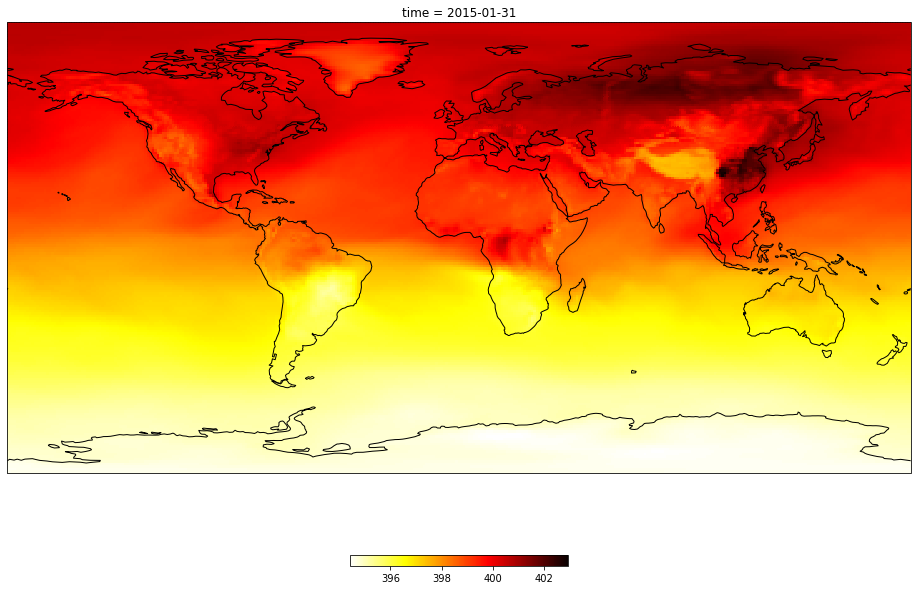

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = co2_data.co2.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r')
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)

ax.set_facecolor('lightblue')

In [ ]:
co2_data.sel(time=pd.to_datetime(co2_data.time.data)[30])

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
    time     datetime64[ns] 2017-07-31
  * lon      (lon) float64 -179.8 -178.8 -177.8 -176.8 ... 177.2 178.2 179.2
  * lat      (lat) float64 89.75 88.75 87.75 86.75 ... -87.25 -88.25 -89.25
Data variables:
    co2      (lat, lon) float64 401.6 401.6 401.6 401.6 ... 401.1 401.1 401.1
Attributes:
    Description:    CO2 data
    Unit:           ppm
    Data document:  TBA

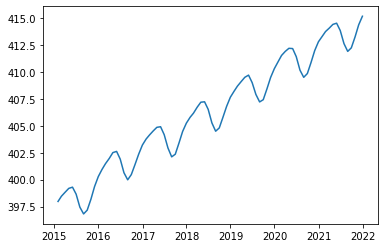

In [ ]:
co2_mean_time_series = co2_data.mean(dim=['lat','lon'])
plt.plot(co2_mean_time_series.time, co2_mean_time_series.co2.data)

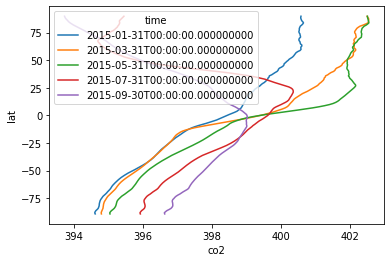

In [ ]:
co2_lat = co2_data.mean(dim=['lon'])
co2_lat['co2'].isel(time=[0, 2, 4, 6, 8]).plot.line(y='lat', hue='time')

## Other operations

- parquet data
- groupby
- find cells in a polygon, then calculating sum or mean...



https://disc.gsfc.nasa.gov/datasets/SNDRAQIL3CMCCP_2/summary

In [ ]:
# gdf = gpd.read_file("D:/pulse_course/Pulse_CO2_CH4-20221219T221922Z-001/Pulse_CO2_CH4/Shapefiles/CONUS_shapefile_EPSG4326/cb_2015_us_state_500k.shp")

## CO data

### Understanding data

In [ ]:
co_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/co.nc')

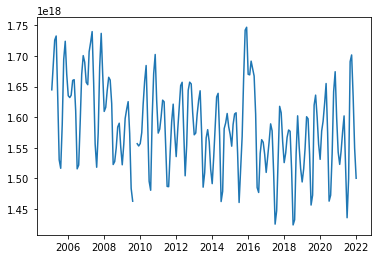

In [ ]:
co_mean_time_series = co_data.mean(dim=['lat','lon'])
plt.plot(co_mean_time_series.time, co_mean_time_series.co.data)

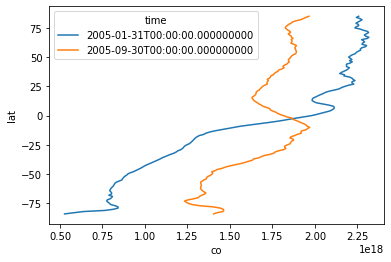

In [ ]:
co_lat = co_data.mean(dim=['lon'])
co_lat['co'].isel(time=[0, 8]).plot.line(y='lat', hue='time')

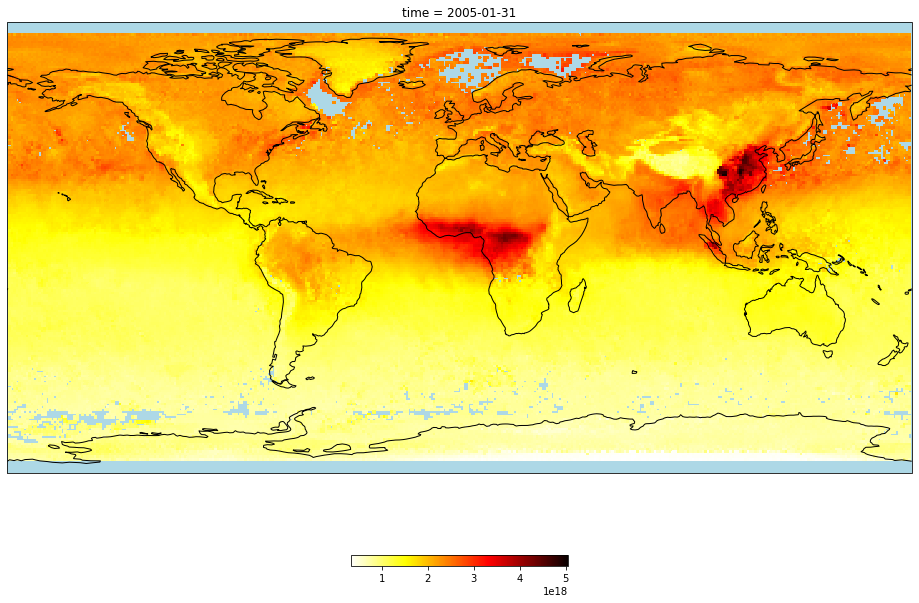

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = co_data.co.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r')
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

## NO2 data

### Understanding data

In [ ]:
no2_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/no2.nc')

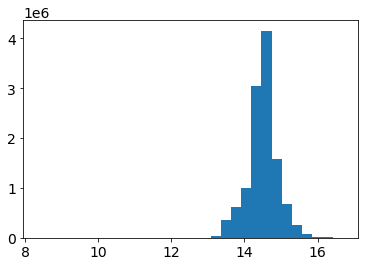

In [ ]:
out = plt.hist(np.log10(no2_data.no2.data.flatten()), bins=30)

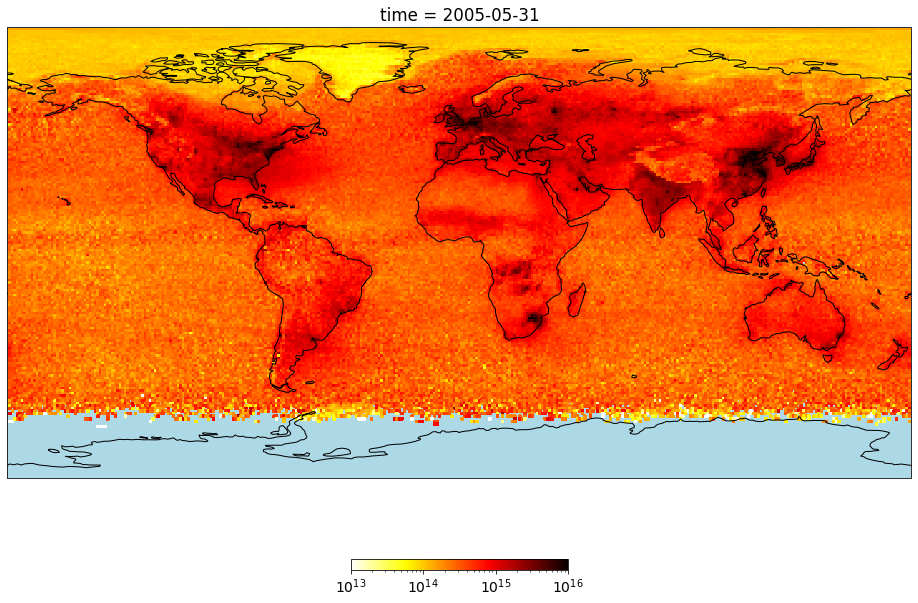

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 4
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = no2_data.no2.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='hot_r', norm=LogNorm(vmin=1e13, vmax=1e16))
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

## CH4 data

### Understanding data

In [ ]:
ch4_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/ch4.nc')

In [ ]:
ch4_data

<xarray.Dataset>
Dimensions:  (time: 3, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-28 2022-03-31 2022-04-30
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 89.97 88.97 87.97 86.97 ... -87.02 -88.02 -89.02
Data variables:
    ch4      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Description:    NO2 data
    Unit:           TBA
    Data document:  TBA

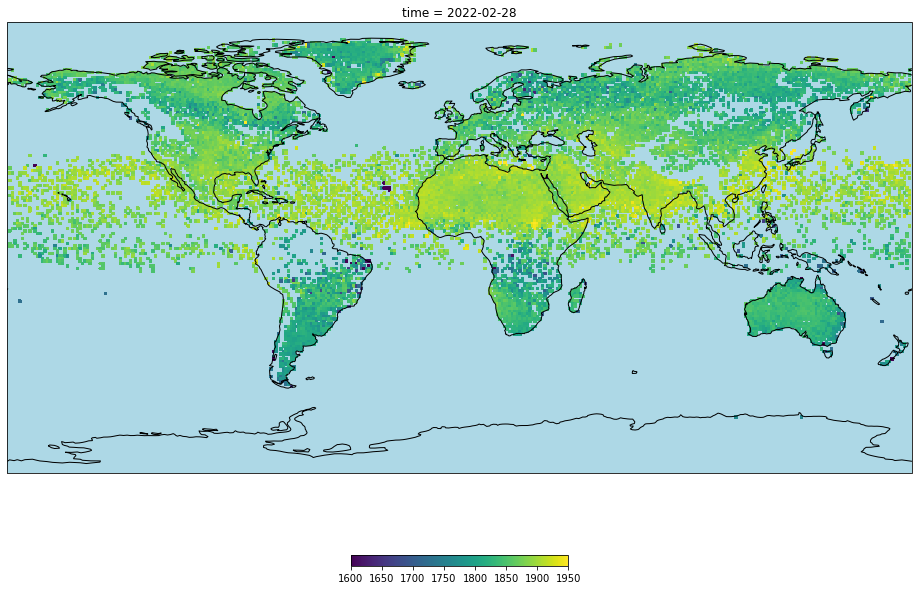

In [ ]:
fig = plt.figure(figsize=(20, 10))
i_time = 0
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.COASTLINE)
# ax.axes.add_feature(cf.LAND);

out = ch4_data.ch4.isel(time=i_time).plot(ax=ax, add_colorbar=False, cmap='viridis', vmin=1600, vmax=1950)
plt.colorbar(out, fraction=0.02, orientation='horizontal')
ax.set_aspect(1)
ax.set_facecolor('lightblue')

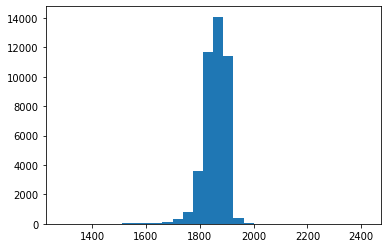

In [ ]:
out = plt.hist(ch4_data.ch4.data.flatten(), bins=30)

In [ ]:
from ipywidgets import widgets, interact
def plot_map(i_time, data_type, scale):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    if data_type == 'co2':
      ds = co2_data.copy()
    elif data_type == 'co':
      ds = co_data.copy()
    elif data_type == 'no2':
      ds = no2_data.copy()
    elif data_type == 'ch4':
      ds = ch4_data.copy()
    norm = None
    if scale == 'log':
      norm = LogNorm()

    out = ds[data_type].isel(time=i_time).plot(
        ax=ax, add_colorbar=False, cmap='hot_r', norm=norm
        # vmin=390, vmax=420
      )
    plt.colorbar(out, fraction=0.02, orientation='horizontal')
    ax.set_aspect(1)
    ax.set_facecolor('lightblue')  
    plt.show()

In [ ]:
interact(
    plot_map, 
    i_time = widgets.IntSlider(min=0, max=83, step=1), 
    data_type=widgets.Select(options=['co2', 'co', 'no2', 'ch4']), 
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=0, description='i_time', max=83), Select(description='data_type', option…

<function __main__.plot_map(i_time, data_type, scale)>